In [1]:
# 1. Import các thư viện cần thiết
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [2]:
# 2. Đọc file csv và gắng index với giá Price
df = pd.read_csv('pre_ADA-USD.csv')
df1 = df['Close'].values.reshape(-1, 1)

In [3]:
# 3. Scaler data
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(df1)

In [4]:
# 4. Chia dữ liệu 9 - 1
train_size = int(0.9 * len(df1))
test_size = len(df1) - train_size

train_data = df1[:train_size]
test_data = df1[train_size:]

print("Train shape:", train_data.shape)
print("Test shape:", test_data.shape)

Train shape: (2056, 1)
Test shape: (229, 1)


In [5]:
# 5. Create dataset
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [6]:
# 6. Chuẩn bị dữ liệu
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

print("x_train: ", x_train.shape)
print("y_train: ", y_train.shape)
print("x_test: ", x_test.shape)
print("y_test", y_test.shape)

x_train:  (1955, 100)
y_train:  (1955,)
x_test:  (128, 100)
y_test (128,)


In [7]:
# 7. Huấn luyện mô hình Linear Regression cho trend
linear_reg = LinearRegression()
linear_reg.fit(x_train, y_train)

LinearRegression()

In [8]:
# 8. Dự đoán trend cho train và test data
trend_train = linear_reg.predict(x_train)
trend_test = linear_reg.predict(x_test)

In [9]:
# 9. Loại bỏ trend khỏi dữ liệu gốc
residual_train = y_train - trend_train
residual_test = y_test - trend_test

In [10]:
# 10. Huấn luyện mô hình Exponential Smoothing cho seasonal component
seasonal_model = ExponentialSmoothing(residual_train, seasonal='add', seasonal_periods=12)
seasonal_fit = seasonal_model.fit()

In [11]:
# 11. Loại bỏ seasonal component khỏi residual
detrended_residual_train = residual_train - seasonal_fit.fittedvalues
detrended_residual_test = residual_test - seasonal_fit.forecast(len(residual_test))

In [12]:
# 12. Huấn luyện mô hình XGBoost cho detrended residual
xgb = XGBRegressor()
xgb.fit(x_train, detrended_residual_train)

[18:39:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [13]:
# 13. Dự đoán detrended residual cho train và test data
residual_train_pred = xgb.predict(x_train)
residual_test_pred = xgb.predict(x_test)

In [14]:
# 14. Kết hợp dự đoán 
y_train_pred = trend_train + seasonal_fit.fittedvalues + residual_train_pred
y_test_pred = trend_test + seasonal_fit.forecast(len(residual_test)) + residual_test_pred

In [15]:
# 15. Tính RMSE, MAPE, MAE
test_rmse = np.sqrt(np.mean((y_test_pred - y_test)**2))
print('Testing RMSE:', test_rmse)

test_mape = np.mean(np.abs((y_test - y_test_pred) / y_test)) * 100
print('Testing MAPE:', test_mape)

test_mae = np.mean(np.abs(y_test - y_test_pred))
print('Testing MAE:', test_mae)

Testing RMSE: 0.009867863635153889
Testing MAPE: 4.2221177028349155
Testing MAE: 0.00755347367210467


In [16]:
# 16. Hàm dự báo cho 30, 60, 90 ngày tiếp theo
def forecast_days(n_days):
    n_steps = 100
    last_100_days = df1[-n_steps:].reshape(1, -1)

    predicted_values = []

    for i in range(n_days):
        trend_next = linear_reg.predict(last_100_days)
        seasonal_next = seasonal_fit.forecast(1)
        residual_next = xgb.predict(last_100_days)
        predicted_next = trend_next + seasonal_next + residual_next
        predicted_values.append(predicted_next)
        last_100_days = np.append(last_100_days[:,1:], predicted_next).reshape(1,-1)

    return np.array(predicted_values)

In [17]:
# 17. Dự báo 30, 60, 90 ngày
forecast_30 = forecast_days(30)
forecast_60 = forecast_days(60)
forecast_90 = forecast_days(90)

In [18]:
# 18. In ra dự đoán cho 30 ngày tiếp theo
print("Dự báo cho 30 ngày tiếp theo:", forecast_30)

Dự báo cho 30 ngày tiếp theo: [[0.14625319]
 [0.14570795]
 [0.14756081]
 [0.14547966]
 [0.15062163]
 [0.14486033]
 [0.14365607]
 [0.14622379]
 [0.13680854]
 [0.13422009]
 [0.13171874]
 [0.13375967]
 [0.12973505]
 [0.1283819 ]
 [0.12884676]
 [0.12641334]
 [0.12672348]
 [0.12554953]
 [0.12417204]
 [0.11716233]
 [0.11441663]
 [0.11343455]
 [0.11426928]
 [0.11309762]
 [0.11006677]
 [0.10845675]
 [0.10603102]
 [0.10458272]
 [0.10141821]
 [0.0989192 ]]


In [19]:
# 18. In ra dự đoán cho 60 ngày tiếp theo
print("Dự báo cho 60 ngày tiếp theo:", forecast_60)

Dự báo cho 60 ngày tiếp theo: [[0.14625319]
 [0.14570795]
 [0.14756081]
 [0.14547966]
 [0.15062163]
 [0.14486033]
 [0.14365607]
 [0.14622379]
 [0.13680854]
 [0.13422009]
 [0.13171874]
 [0.13375967]
 [0.12973505]
 [0.1283819 ]
 [0.12884676]
 [0.12641334]
 [0.12672348]
 [0.12554953]
 [0.12417204]
 [0.11716233]
 [0.11441663]
 [0.11343455]
 [0.11426928]
 [0.11309762]
 [0.11006677]
 [0.10845675]
 [0.10603102]
 [0.10458272]
 [0.10141821]
 [0.0989192 ]
 [0.09364685]
 [0.09510354]
 [0.09550257]
 [0.0929444 ]
 [0.09483561]
 [0.09839592]
 [0.09371955]
 [0.08976607]
 [0.08656637]
 [0.08088699]
 [0.07944364]
 [0.07620799]
 [0.07630823]
 [0.07146291]
 [0.07228275]
 [0.07264551]
 [0.07512139]
 [0.07467082]
 [0.07099264]
 [0.06865243]
 [0.06718627]
 [0.0665898 ]
 [0.06604235]
 [0.06515132]
 [0.06371677]
 [0.06086715]
 [0.06152294]
 [0.05907643]
 [0.05885185]
 [0.05767062]]


In [20]:
# 18. In ra dự đoán cho 90 ngày tiếp theo
print("Dự báo cho 90 ngày tiếp theo:", forecast_90)

Dự báo cho 90 ngày tiếp theo: [[0.14625319]
 [0.14570795]
 [0.14756081]
 [0.14547966]
 [0.15062163]
 [0.14486033]
 [0.14365607]
 [0.14622379]
 [0.13680854]
 [0.13422009]
 [0.13171874]
 [0.13375967]
 [0.12973505]
 [0.1283819 ]
 [0.12884676]
 [0.12641334]
 [0.12672348]
 [0.12554953]
 [0.12417204]
 [0.11716233]
 [0.11441663]
 [0.11343455]
 [0.11426928]
 [0.11309762]
 [0.11006677]
 [0.10845675]
 [0.10603102]
 [0.10458272]
 [0.10141821]
 [0.0989192 ]
 [0.09364685]
 [0.09510354]
 [0.09550257]
 [0.0929444 ]
 [0.09483561]
 [0.09839592]
 [0.09371955]
 [0.08976607]
 [0.08656637]
 [0.08088699]
 [0.07944364]
 [0.07620799]
 [0.07630823]
 [0.07146291]
 [0.07228275]
 [0.07264551]
 [0.07512139]
 [0.07467082]
 [0.07099264]
 [0.06865243]
 [0.06718627]
 [0.0665898 ]
 [0.06604235]
 [0.06515132]
 [0.06371677]
 [0.06086715]
 [0.06152294]
 [0.05907643]
 [0.05885185]
 [0.05767062]
 [0.05576934]
 [0.05280126]
 [0.05326384]
 [0.05473907]
 [0.05237649]
 [0.05343849]
 [0.05100846]
 [0.04882325]
 [0.04638482]
 [0.

<function matplotlib.pyplot.show(close=None, block=None)>

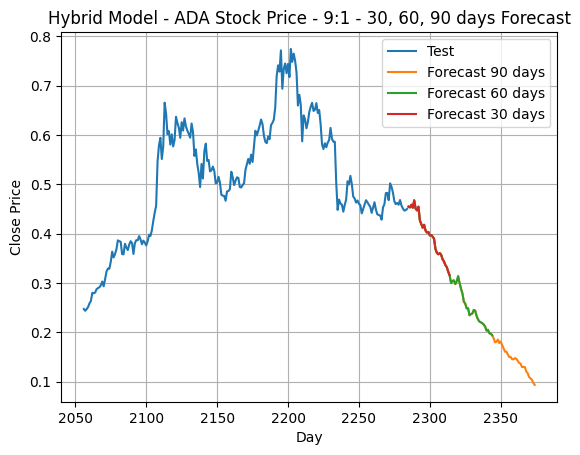

In [21]:
# Vẽ biểu đồ

# Vẽ dữ liệu kiểm tra
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index, scaler.inverse_transform(test_data), label='Test')

# Vẽ dự báo 90, 60, 30 ngày
predict_data_index_90 = pd.RangeIndex(start=len(df1), stop=len(df1)+90, step=1)
plt.plot(predict_data_index_90, scaler.inverse_transform(np.array(forecast_90).reshape(-1, 1)), label='Forecast 90 days')

predict_data_index_60 = pd.RangeIndex(start=len(df1), stop=len(df1)+60, step=1)
plt.plot(predict_data_index_60, scaler.inverse_transform(np.array(forecast_60).reshape(-1, 1)), label='Forecast 60 days')

predict_data_index_30 = pd.RangeIndex(start=len(df1), stop=len(df1)+30, step=1)
plt.plot(predict_data_index_30, scaler.inverse_transform(np.array(forecast_30).reshape(-1, 1)), label='Forecast 30 days')


plt.title('Hybrid Model - ADA Stock Price - 9:1 - 30, 60, 90 days Forecast')
plt.legend()
plt.xlabel('Day')
plt.ylabel('Close Price')
plt.grid()
plt.show